In [2]:
import glob
import pandas as pd
import os

path = "../data/GeneratedLabelledFlows/TrafficLabelling/"
csv_files = glob.glob(os.path.join(path, "*.csv"))

print(f"Found {len(csv_files)} CSV files.")

df = pd.concat(
    [pd.read_csv(f, low_memory=False, encoding='ISO-8859-1') for f in csv_files],
    ignore_index=True
)

print("Merged DataFrame shape:", df.shape)
df.head()



Found 8 CSV files.
Merged DataFrame shape: (3119345, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443.0,192.168.10.5,54865.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80.0,192.168.10.5,55054.0,6.0,7/7/2017 3:30,109.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80.0,192.168.10.5,55055.0,6.0,7/7/2017 3:30,52.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443.0,192.168.10.16,46236.0,6.0,7/7/2017 3:30,34.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443.0,192.168.10.5,54863.0,6.0,7/7/2017 3:30,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [3]:
#We should remove unnamed columns and columns that are completely empty
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.dropna(axis=1, how='all', inplace=True)

In [11]:
print(df.columns.tolist())

['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', 

In [13]:
# Strip column names to remove extra spaces
df.columns = df.columns.str.strip()

In [14]:
# Check unique values in 'Label' column
# Convert 'Label' column to binary values: 0 for 'BENIGN', 1 for others
print(df['Label'].unique())

df['Label'] = df['Label'].apply(
    lambda x: 0 if isinstance(x, str) and x.strip().upper() == 'BENIGN' else 1
)

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack \x96 Brute Force' 'Web Attack \x96 XSS'
 'Web Attack \x96 Sql Injection' nan 'FTP-Patator' 'SSH-Patator'
 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']


In [15]:
# The following columns are often not useful for traffic pattern analysis:
# 'Flow ID' is often a unique identifier for each flow, 'Timestamp' indicates the time of the flow and can cause overfitting,
# 'Src IP' and 'Dst IP' are the source and destination IP addresses, which can be sensitive information,
# 'Src Port' and 'Dst Port' are the source and destination ports, and
# 'Protocol' indicates the protocol used (e.g., TCP, UDP). These columns are not necessary for the analysis of the traffic patterns.
# They can be dropped to focus on the features that are more relevant for classification tasks.
drop_cols = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Protocol']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)


In [16]:
# Remove non-numeric columns
# This is important because many machine learning algorithms require numeric input and we can't encode them to numeric values as they have High-cardinality: Many unique values → encoding them may explode feature space.
non_numeric = df.select_dtypes(include=['object']).columns
df.drop(columns=non_numeric, inplace=True)

In [17]:
# Avoid dividing by zero as an example in Average Packet Rate, Flow Bytes/s
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


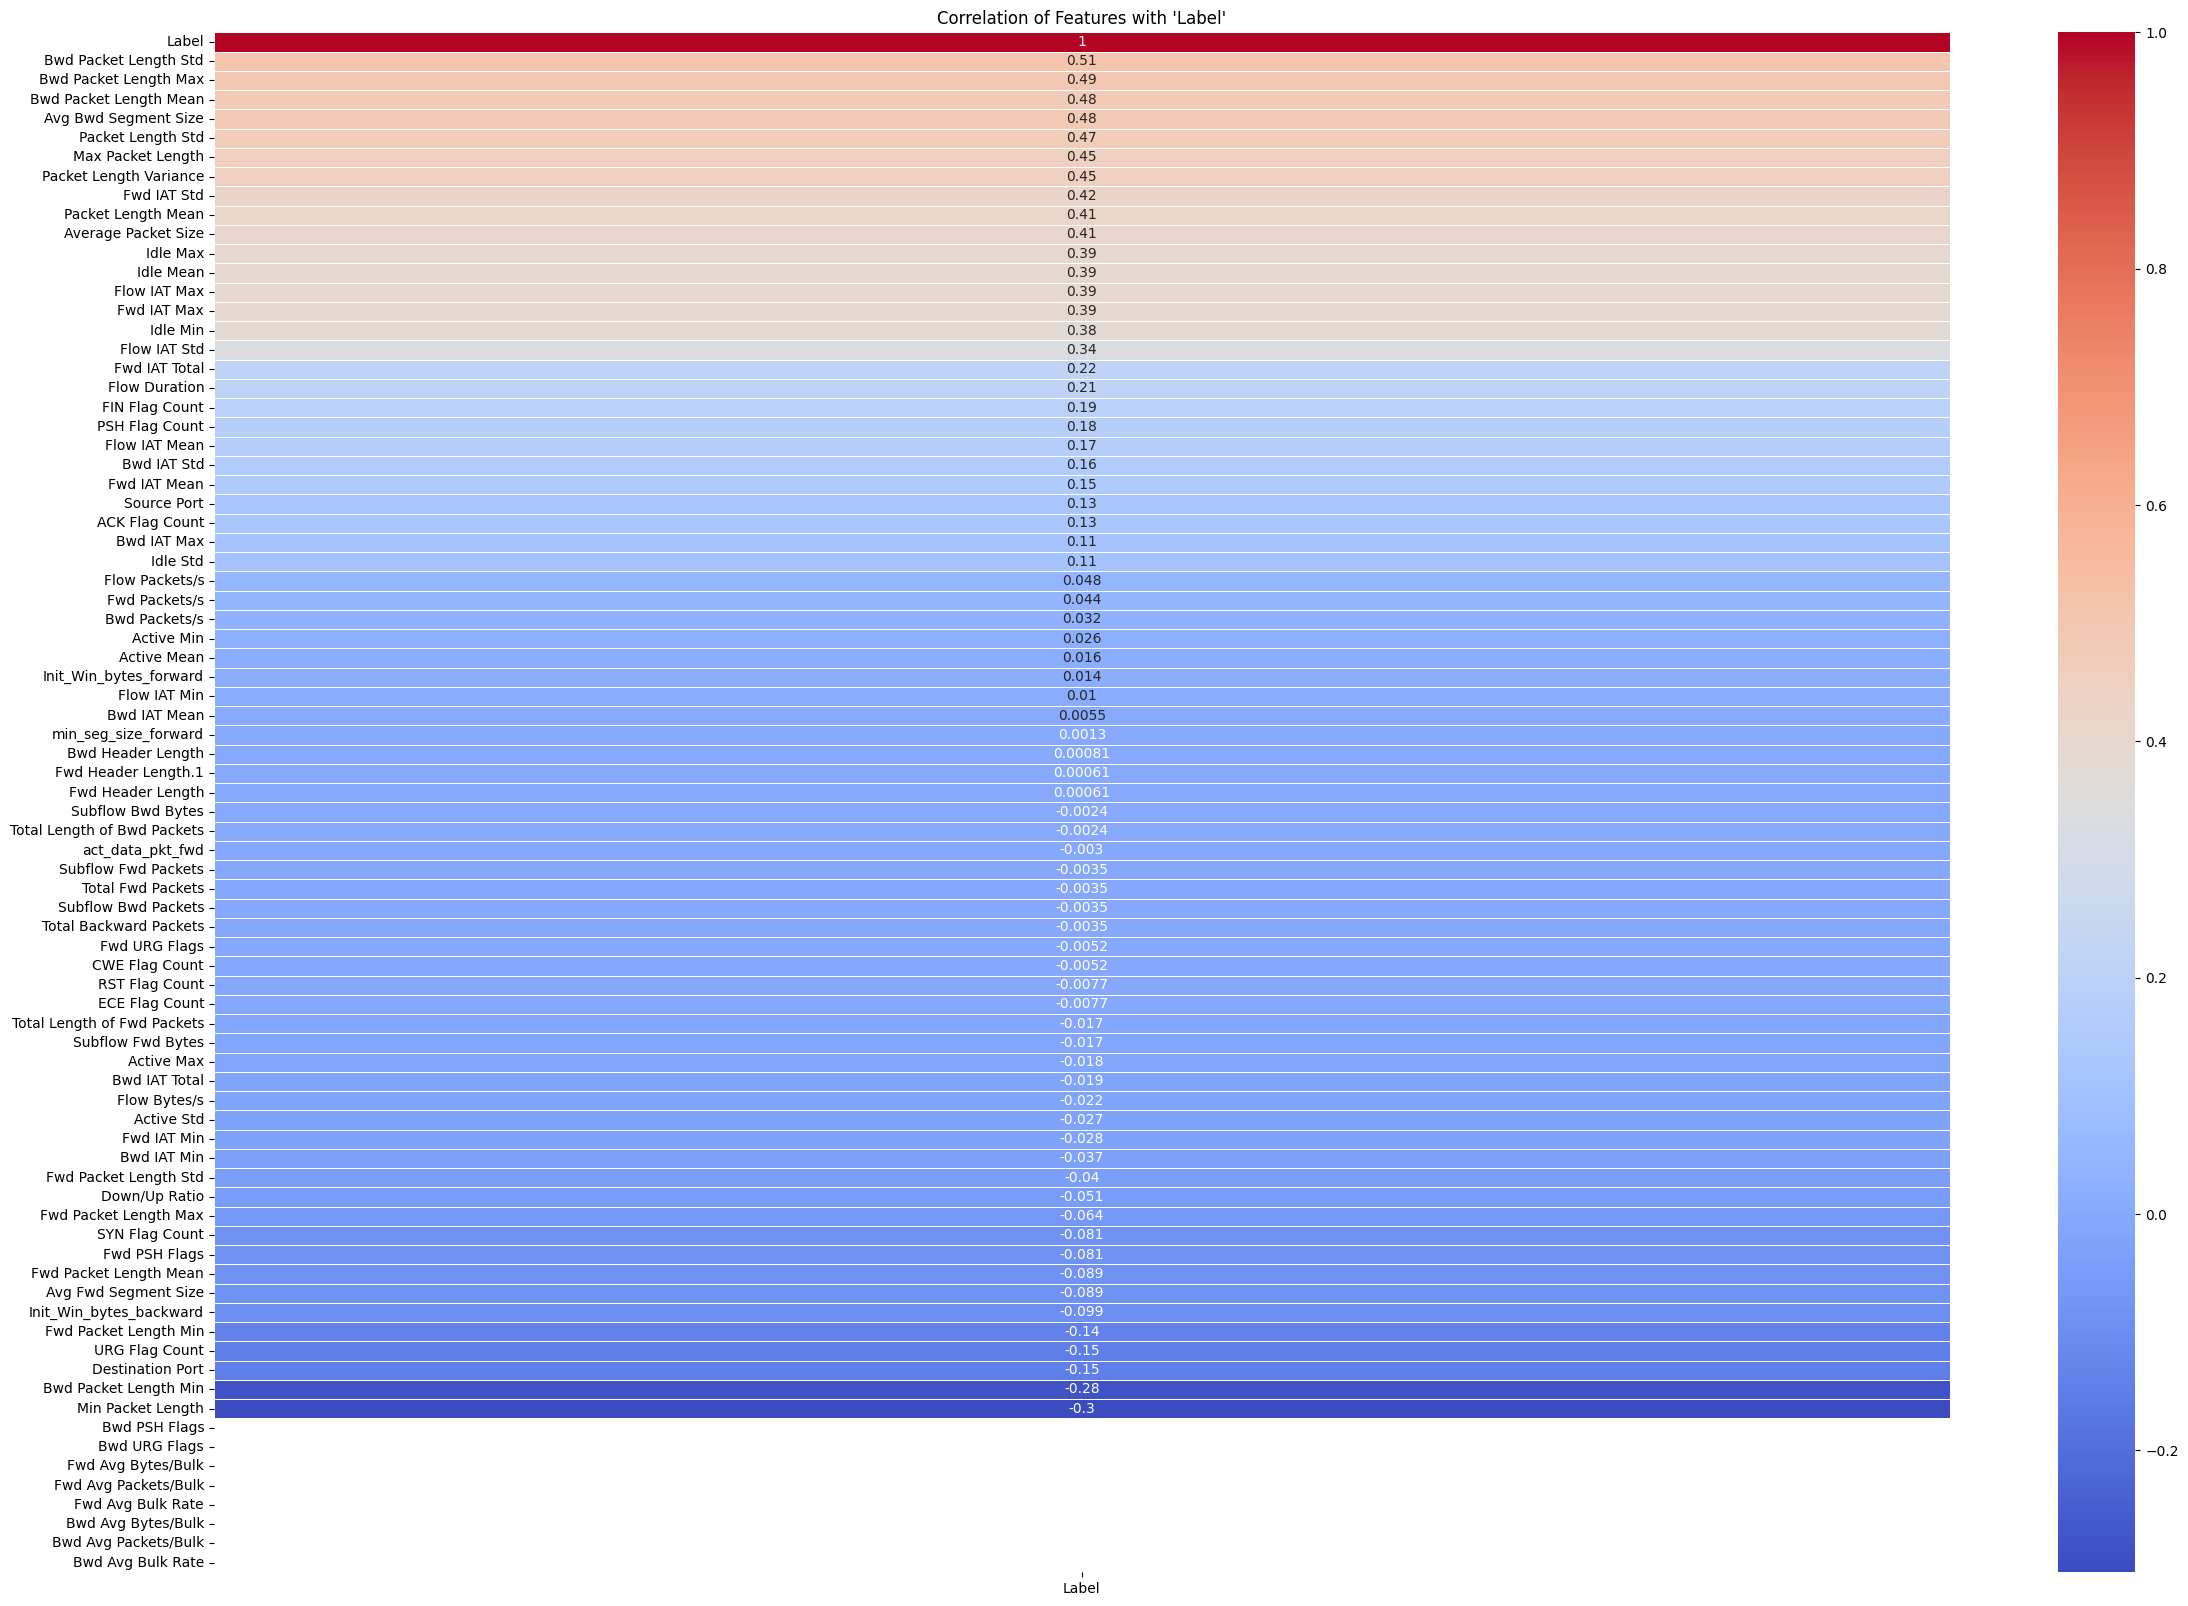

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap of correlation with the target label
plt.figure(figsize=(28, 20))
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation of Features with 'Label'")
plt.show()


In [24]:
# Compute correlation matrix
corr_matrix = df.corr()

# Extract correlations with the label column
corr_with_target = corr_matrix['Label']  

# Select features with strong correlation
strong_corr_features = corr_with_target[abs(corr_with_target) > 0.1].index.tolist()

# Select only those columns
df_filtered = df[strong_corr_features]  # keep target column

print(f"Filtered DataFrame shape: {df_filtered.shape}")


Filtered DataFrame shape: (2827876, 33)


In [26]:
# Ensure the directory exists
os.makedirs("../data/processed", exist_ok=True)

# Save
df_filtered.to_csv("../data/processed/filtered_dataset.csv", index=False)

print("Filtered dataset saved to '../data/processed/filtered_dataset.csv'.")

Filtered dataset saved to '../data/processed/filtered_dataset.csv'.
